In [1]:
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.stats import wilcoxon, binom
import numpy as np

In [2]:
model_df = pd.read_csv("~/watanabe/Divagar/CCLE_data/Model.csv")
tpm_df = pd.read_csv("~/watanabe/Divagar/CCLE_data/OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected.csv")
cn_df = pd.read_csv("~/watanabe/Divagar/CCLE_data/OmicsCNGene.csv")

In [3]:
# filter the SCLC cell lines
sclc_model_df = model_df[model_df['OncotreeSubtype']=='Small Cell Lung Cancer']
sclc_model_df = sclc_model_df[['ModelID','StrippedCellLineName']]

In [4]:
# Unnamed is the ModelID column for tpm_df
sclc_genes_tpm_df = tpm_df[['Unnamed: 0','MYCL (4610)','MYC (4609)', 'MYCN (4613)', 'ASCL1 (429)', 'NEUROD1 (4760)', 'POU2F3 (25833)']].copy()

In [5]:
sclc_genes_tpm_df.rename(columns=
    {'Unnamed: 0': 'ModelID',
    'MYCL (4610)':'MYCL TPM',
    'MYC (4609)': 'MYC TPM',
    'MYCN (4613)': 'MYCN TPM', 
    'ASCL1 (429)': 'ASCL1 TPM', 
    'NEUROD1 (4760)': 'NEUROD1 TPM', 
    'POU2F3 (25833)': 'POU2F3 TPM'
}, inplace=True)

In [6]:
sclc_genes_cn_df = cn_df[['Unnamed: 0','MYCL (4610)','MYC (4609)', 'MYCN (4613)', 'ASCL1 (429)', 'NEUROD1 (4760)', 'POU2F3 (25833)']].copy()

In [7]:
sclc_genes_cn_df.rename(columns=
    {'Unnamed: 0': 'ModelID',
    'MYCL (4610)':'MYCL CN',
    'MYC (4609)': 'MYC CN',
    'MYCN (4613)': 'MYCN CN', 
    'ASCL1 (429)': 'ASCL1 CN', 
    'NEUROD1 (4760)': 'NEUROD1 CN', 
    'POU2F3 (25833)': 'POU2F3 CN'
}, inplace=True)

In [34]:
merge1_df = pd.merge(sclc_model_df,sclc_genes_tpm_df, on='ModelID')
sclc_merged_df = pd.merge(merge1_df, sclc_genes_cn_df, on='ModelID')

In [9]:
subtype_mapping = {
    'ASCL1 TPM': 'SCLC-A',
    'NEUROD1 TPM': 'SCLC-N',
    'POU2F3 TPM': 'SCLC-P'
}

In [36]:
# creates a new column called 'SCLC subtype'
# .idxmax(axis=1) looks at each index (cell line) and finds the highest TPM for ASCL1, NEUROD1 and POU2F3
sclc_merged_df['SCLC subtype'] = sclc_merged_df[['ASCL1 TPM', 'NEUROD1 TPM', 'POU2F3 TPM']].idxmax(axis=1).map(subtype_mapping)

In [13]:
# look at the first index/row/cell line of df
def custom_sort(df):
    if df['SCLC subtype'].iloc[0] == 'SCLC-A':
        return df.sort_values(by='ASCL1 TPM', ascending=False)
    elif df['SCLC subtype'].iloc[0] == 'SCLC-N':
        return df.sort_values(by='NEUROD1 TPM', ascending=False)
    elif df['SCLC subtype'].iloc[0] == 'SCLC-P':
        return df.sort_values(by='POU2F3 TPM', ascending=False)

In [37]:
# .groupby() groups the df by the subtype
# .apply() is applied to subset dfs of each subtype after the .groupby()
sclc_merged_df = sclc_merged_df.groupby(by='SCLC subtype', group_keys=False).apply(lambda group: custom_sort(group))


/tmp/ipykernel_1653686/993476868.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sclc_merged_df = sclc_merged_df.groupby(by='SCLC subtype', group_keys=False).apply(lambda group: custom_sort(group))


In [39]:
#remove the cell lines that are not clearly one subtype
sclc_merged_df.reset_index(drop=True, inplace=True)
cells_to_remove = ['NCIH2286','SBC5','NCIH1607','CORL26', 'NCIH2227', 'HCC33']

In [40]:
sclc_merged_df = sclc_merged_df[~sclc_merged_df['StrippedCellLineName'].isin(cells_to_remove)]

In [41]:
plot_heatmap_tpm_df = sclc_merged_df[['StrippedCellLineName','ASCL1 TPM', 'NEUROD1 TPM', 'POU2F3 TPM','MYCL TPM', 'MYC TPM', 'MYCN TPM', 'SCLC subtype']]
plot_heatmap_tpm_df.set_index('StrippedCellLineName', inplace=True)
expression_df = plot_heatmap_tpm_df.drop(columns=['SCLC subtype'])

# Get the indices for the chunks
chunk1 = expression_df.loc[:'NCIH69']
chunk2 = expression_df.loc['CORL279':'NCIH82']
chunk3 = expression_df.loc['NCIH526':'NCIH1450']

In [42]:
gene_rename_dict = {
    'ASCL1 TPM': 'ASCL1',
    'NEUROD1 TPM': 'NEUROD1',
    'POU2F3 TPM': 'POU2F3',
    'MYCL TPM': 'MYCL',
    'MYC TPM': 'MYC',
    'MYCN TPM': 'MYCN'
}

# make the cell lines the columns
chunk1_renamed = chunk1.T.rename(index=gene_rename_dict)
chunk2_renamed = chunk2.T.rename(index=gene_rename_dict)
chunk3_renamed = chunk3.T.rename(index=gene_rename_dict)

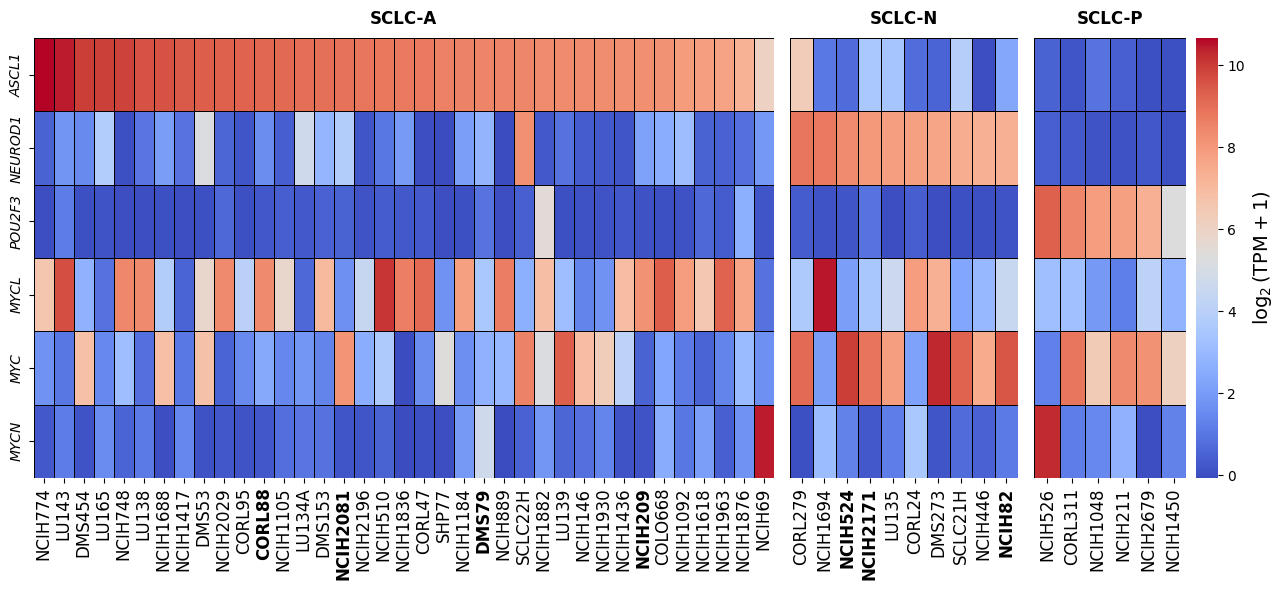

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 6), gridspec_kw={'width_ratios': [39, 12, 10]})

vmin = expression_df.min().min()
vmax = expression_df.max().max()

# cell lines of interest
bold_cell_lines = ['DMS79', 'CORL88', 'NCIH209','NCIH2081','NCIH2171','NCIH524','NCIH82']

sns.heatmap(chunk1_renamed, annot=False, cmap="coolwarm", cbar=False,
    linewidths=0.5, linecolor='black', xticklabels=True, yticklabels=True, ax=ax1, vmin=vmin, vmax=vmax)
ax1.set_title('SCLC-A', pad=10,fontweight='bold')
ax1.set_xlabel('')

xticklabels = ax1.get_xticklabels()
for label in xticklabels:
    if label.get_text() in bold_cell_lines:
        label.set_fontweight('bold')

sns.heatmap(chunk2_renamed, annot=False, cmap="coolwarm", cbar=False,
    linewidths=0.5, linecolor='black', xticklabels=True, yticklabels=False, ax=ax2, vmin=vmin, vmax=vmax)
ax2.set_title('SCLC-N', pad=10,fontweight='bold')
ax2.set_xlabel('')

xticklabels = ax2.get_xticklabels()
for label in xticklabels:
    if label.get_text() in bold_cell_lines:
        label.set_fontweight('bold')

sns.heatmap(chunk3_renamed, annot=False, cmap="coolwarm", cbar_kws={'label': 'Expression in log2(TPM+1)'},
    linewidths=0.5, linecolor='black', xticklabels=True, yticklabels=False, ax=ax3, vmin=vmin, vmax=vmax)
ax3.set_title('SCLC-P', pad=10,fontweight='bold')
ax3.set_xlabel('')

xticklabels = ax3.get_xticklabels()
for label in xticklabels:
    if label.get_text() in bold_cell_lines:
        label.set_fontweight('bold')

colorbar = ax3.collections[0].colorbar
colorbar.set_label(r'$\log_2(\text{TPM} + 1)$', fontsize=14)

for ax in (ax1, ax2, ax3):
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10, fontstyle='italic')

plt.tight_layout()
#plt.savefig('./plots/sclc_subtype_myc_family_heatmap.png', dpi=600, bbox_inches='tight')

In [47]:
sclc_a_df = sclc_merged_df[sclc_merged_df['SCLC subtype'] == 'SCLC-A']
sclc_n_df = sclc_merged_df[sclc_merged_df['SCLC subtype'] == 'SCLC-N']
sclc_p_df = sclc_merged_df[sclc_merged_df['SCLC subtype'] == 'SCLC-P']


In [48]:
def calculate_p_value(df, column1, column2):
    # Perform Wilcoxon signed-rank test
    stat, p_value = wilcoxon(df[column1], df[column2])
    return p_value

In [49]:
def calculate_p_value_2(df, column1, column2):
    df['differences'] = df[column1] - df[column2]
    #ignore 0s and treat CN +- 2 as equal
    positive_diff = np.sum(df['differences'] > 2)
    negative_diff = np.sum(df['differences'] < -2)
    print(positive_diff)
    print(negative_diff)
    # The null hypothesis is that the probability of getting a positive difference is 0.5 
    n = positive_diff + negative_diff
    p_value = binom.cdf(positive_diff, n, p=0.5)
    if p_value < 0.5:
        # 2 sided test
        p_value *= 2
    elif p_value > 0.5:
        # 2 sided test
        p_value = (1-p_value) * 2
    return p_value

/tmp/ipykernel_1653686/398533215.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long_a, x='Gene', y='TPM', palette="Set2", width=0.3, inner=None, ax=axes[0])
/tmp/ipykernel_1653686/398533215.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long_n, x='Gene', y='TPM', palette="Set2", width=0.3, inner=None, ax=axes[1])
/tmp/ipykernel_1653686/398533215.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long_p, x='Gene', y='TPM', palette="Set2", width=0.3, inner=None, ax=axes[2])
/tmp/ipykernel_1653686/

SCLC-N P-value: 3.223e-01
SCLC-N P-value: 3.223e-01


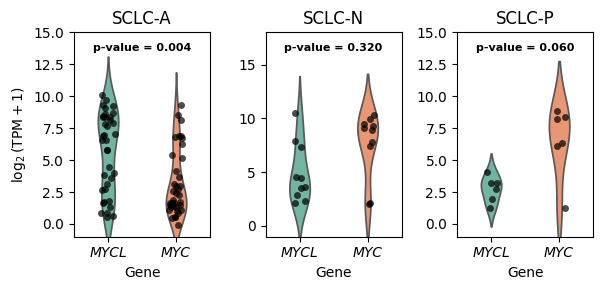

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(6, 3))

df_long_a = sclc_a_df[['MYCL TPM', 'MYC TPM']].melt(var_name='Gene', value_name='TPM')
df_long_a['Gene'] = df_long_a['Gene'].str.replace(' TPM', '', regex=False)

sns.violinplot(data=df_long_a, x='Gene', y='TPM', palette="Set2", width=0.3, inner=None, ax=axes[0])
sns.stripplot(data=df_long_a, x='Gene', y='TPM', color='black', alpha=0.7, jitter=True, dodge=False, ax=axes[0])
axes[0].set_title('SCLC-A', fontsize=12)
axes[0].set_ylabel(r'$\log_2(\text{TPM} + 1)$', fontsize=10)
axes[0].set_ylim(-1,15)

# Calculate p-value for SCLC-A
p_value_a = calculate_p_value(sclc_a_df, 'MYCL TPM', 'MYC TPM')

# Annotate p-value on the plot
axes[0].annotate(f'p-value = {p_value_a:.3f}', xy=(0.5, 0.9), ha='center', va='bottom', fontsize=8,
                 color='black', xycoords='axes fraction', fontweight='bold')

df_long_n = sclc_n_df[['MYCL TPM', 'MYC TPM']].melt(var_name='Gene', value_name='TPM')
df_long_n['Gene'] = df_long_n['Gene'].str.replace(' TPM', '', regex=False)

sns.violinplot(data=df_long_n, x='Gene', y='TPM', palette="Set2", width=0.3, inner=None, ax=axes[1])
sns.stripplot(data=df_long_n, x='Gene', y='TPM', color='black', alpha=0.7, jitter=True, dodge=False, ax=axes[1])
axes[1].set_title('SCLC-N', fontsize=12)
axes[1].set_ylabel('', fontsize=1)
axes[1].set_ylim(-1,18)

# Calculate p-value for SCLC-N
p_value_n = calculate_p_value(sclc_n_df, 'MYCL TPM', 'MYC TPM')
print(f"SCLC-N P-value: {p_value_n:.3e}") 

p_value_n_rounded = round(p_value_n, 2)

axes[1].annotate(f'p-value = {p_value_n_rounded:.3f}', xy=(0.5, 0.9), ha='center', va='bottom', fontsize=8,
                 color='black', xycoords='axes fraction', fontweight='bold')

df_long_p = sclc_p_df[['MYCL TPM', 'MYC TPM']].melt(var_name='Gene', value_name='TPM')
df_long_p['Gene'] = df_long_p['Gene'].str.replace(' TPM', '', regex=False)
sns.violinplot(data=df_long_p, x='Gene', y='TPM', palette="Set2", width=0.3, inner=None, ax=axes[2])
sns.stripplot(data=df_long_p, x='Gene', y='TPM', color='black', alpha=0.7, jitter=True, dodge=False, ax=axes[2])
axes[2].set_title('SCLC-P', fontsize=12)
axes[2].set_ylabel('', fontsize=1)
axes[2].set_ylim(-1,15)


p_value_p = calculate_p_value(sclc_p_df, 'MYCL TPM', 'MYC TPM')
print(f"SCLC-N P-value: {p_value_n:.3e}") 

p_value_p_rounded = round(p_value_p, 2)

axes[2].annotate(f'p-value = {p_value_p_rounded:.3f}', xy=(0.5, 0.9), ha='center', va='bottom', fontsize=8,
                 color='black', xycoords='axes fraction', fontweight='bold')

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, fontstyle='italic')

plt.tight_layout()
#plt.savefig('./plots/sclc_subtype_myc_tpm_wilcox.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_1653686/1929472925.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long_a, x='Gene', y='CN', palette="Set2", width=0.3, inner=None, ax=axes[0])
/tmp/ipykernel_1653686/870978910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['differences'] = df[column1] - df[column2]
/tmp/ipykernel_1653686/1929472925.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long_n, x='Gene', y='CN', palette="Set2", width=0.3

13
3
SCLC-A P-value: 4.181e-03
2
8
SCLC-N P-value: 1.094e-01
0
3
SCLC-P P-value: 1.094e-01


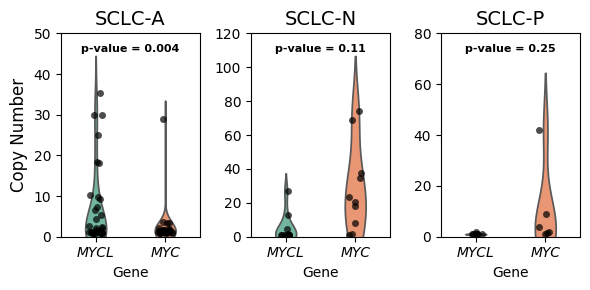

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(6, 3))

sclc_a_cn_df = sclc_merged_df[sclc_merged_df['SCLC subtype'] == 'SCLC-A']
df_long_a = sclc_a_cn_df[['MYCL CN', 'MYC CN']].melt(var_name='Gene', value_name='CN')
df_long_a['Gene'] = df_long_a['Gene'].str.replace(' CN', '', regex=False)
sns.violinplot(data=df_long_a, x='Gene', y='CN', palette="Set2", width=0.3, inner=None, ax=axes[0])
sns.stripplot(data=df_long_a, x='Gene', y='CN', color='black', alpha=0.7, jitter=True, dodge=False, ax=axes[0])
axes[0].set_title('SCLC-A', fontsize=14)
axes[0].set_ylabel('Copy Number', fontsize=12)
axes[0].set_ylim(0,50)


# Calculate p-value for SCLC-A
p_value_a = calculate_p_value_2(sclc_a_df, 'MYCL CN', 'MYC CN')
print(f"SCLC-A P-value: {p_value_a:.3e}")  
p_value_a_rounded = round(p_value_a, 3)

axes[0].annotate(f'p-value = {p_value_a_rounded:.3f}', xy=(0.5, 0.9), ha='center', va='bottom', fontsize=8,
                 color='black', xycoords='axes fraction', fontweight='bold')

sclc_n_cn_df = sclc_merged_df[sclc_merged_df['SCLC subtype'] == 'SCLC-N']
df_long_n = sclc_n_cn_df[['MYCL CN', 'MYC CN']].melt(var_name='Gene', value_name='CN')
df_long_n['Gene'] = df_long_n['Gene'].str.replace(' CN', '', regex=False)
sns.violinplot(data=df_long_n, x='Gene', y='CN', palette="Set2", width=0.3, ax=axes[1], inner=None)
sns.stripplot(data=df_long_n, x='Gene', y='CN', color='black', alpha=0.7, jitter=True, dodge=False, ax=axes[1])
axes[1].set_title('SCLC-N', fontsize=14)
axes[1].set_ylabel('', fontsize=1)
axes[1].set_ylim(0,120)


p_value_n = calculate_p_value_2(sclc_n_df, 'MYCL CN', 'MYC CN')
print(f"SCLC-N P-value: {p_value_n:.3e}")  

p_value_n_rounded = round(p_value_n, 2)

axes[1].annotate(f'p-value = {p_value_n_rounded:.2f}', xy=(0.5, 0.9), ha='center', va='bottom', fontsize=8,
                 color='black', xycoords='axes fraction', fontweight='bold')

sclc_p_cn_df = sclc_merged_df[sclc_merged_df['SCLC subtype'] == 'SCLC-P']
df_long_p = sclc_p_cn_df[['MYCL CN', 'MYC CN']].melt(var_name='Gene', value_name='CN')
df_long_p['Gene'] = df_long_p['Gene'].str.replace(' CN', '', regex=False)
sns.violinplot(data=df_long_p, x='Gene', y='CN', palette="Set2", width=0.3, ax=axes[2], inner=None)
sns.stripplot(data=df_long_p, x='Gene', y='CN', color='black', alpha=0.7, jitter=True, dodge=False, ax=axes[2])
axes[2].set_title('SCLC-P', fontsize=14)
axes[2].set_ylabel('', fontsize=1)
axes[2].set_ylim(0,80)


# Calculate p-value for SCLC-N
p_value_p = calculate_p_value_2(sclc_p_df, 'MYCL CN', 'MYC CN')
print(f"SCLC-P P-value: {p_value_n:.3e}")  

p_value_p_rounded = round(p_value_p, 2)

axes[2].annotate(f'p-value = {p_value_p_rounded:.2f}', xy=(0.5, 0.9), ha='center', va='bottom', fontsize=8,
                 color='black', xycoords='axes fraction', fontweight='bold')
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, fontstyle='italic')
    
plt.tight_layout()
#plt.savefig('./plots/sclc_subtype_myc_wilcox_cn.png', dpi=600, bbox_inches='tight')